In [19]:
import matplotlib.pyplot as plt
plt.style.use(['seaborn-darkgrid'])
import pymc3 as pm
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from theano.compile.ops import as_op
import theano.tensor as tt

Running on PyMC3 v3.4.1


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS failed. Falling back to elementwise auto-assignment.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Slice: [14_interval__]
>Slice: [13_interval__]
>Slice: [12_interval__]
>Slice: [11_interval__]
>Slice: [10_interval__]
>Slice: [9_interval__]
>Slice: [8_interval__]
>Slice: [7_interval__]
>Slice: [6_interval__]
>Slice: [5_interval__]
>Slice: [4_interval__]
>Slice: [3_interval__]
>Slice: [2_interval__]
>Slice: [1_interval__]
>Slice: [0_interval__]
>Slice: [index_interval__]
>Slice: [amp_interval__]
Could not pickle model, sampling singlethreaded.
Sequential sampling (2 chains in 1 job)
CompoundStep
>Slice: [14_interval__]
>Slice: [13_interval__]
>Slice: [12_interval__]
>Slice: [11_interval__]
>Slice: [10_interval__]
>Slice: [9_interval__]
>Slice: [8_interval__]
>Slice: [7_interval__]
>Slice: [6_interval__]
>Slice: [5_interval__]
>Slice: [4_interval__]
>Slice: [3_interval__]
>Slice: [2_i

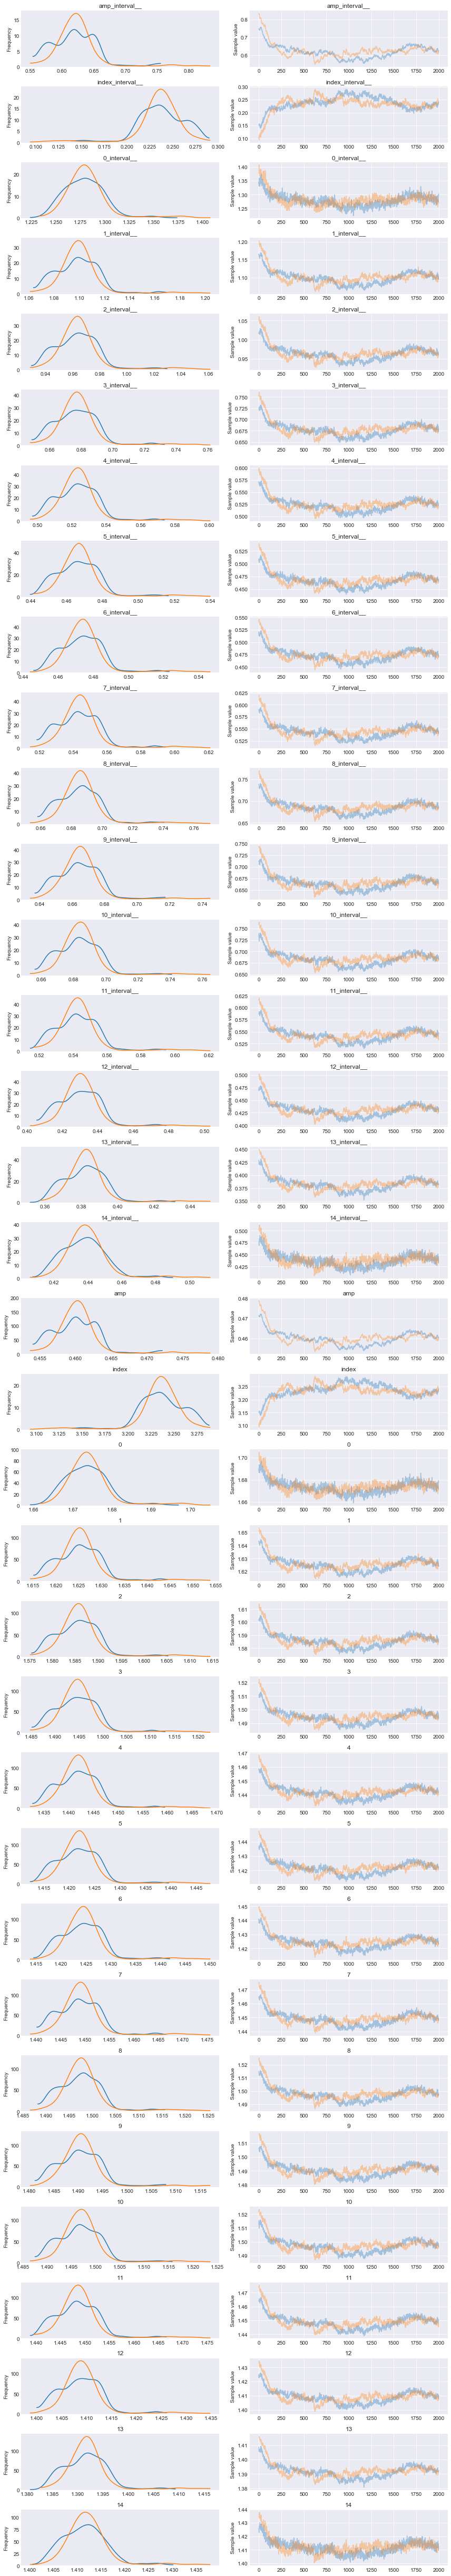

In [56]:



#checking verison of pymc3
print('Running on PyMC3 v{}'.format(pm.__version__))
#inputting data
#data_base = np.loadtxt("Lyman_alpha_result_balout_z=3.2-3.3_testing.txt")
data_z = np.loadtxt("/Users/Jenny/Documents/pycodes/specdb/specdb/data/DB/Lyman_alpha_result_balout_z_ratio_mcmc_1075-1600_avecombine_highz_newbin_cut1075snr>2.2.txt")
data_all = np.loadtxt("/Users/Jenny/Documents/pycodes/specdb/specdb/data/DB/Lyman_alpha_result_balout_z>2.5_3.2base_1075-1600_mcmcflux_avecombine_highz_newbin_cut1075snr>2.2.txt")
data_error = np.loadtxt("Lyman_alpha_binning_flux_covariance_z>2.5-4.8_1075-1150_3.2base_dr14_newbin_corrected.txt")
data_z = data_z[:,0]
prtint (data_z)
i = range(0, len(data_all))
data_indi_flux = np.split(data_all[i,1], len(data_z))
data_indi_wave = np.split(data_all[i,0], len(data_z))
data_error_split = np.split(data_error, len(data_z))
#using schaye metal correction
data_indi_tau = [0.146,0.187,0.229,0.280,0.36]
data_redshift_base = [2.0,2.2,2.4,2.6,2.8]
data_error_base = [0.018,0.013,0.009,0.01,0.012]
data_indi_flux_final = np.append(data_indi_flux,np.array(data_indi_tau))
data_error_final=np.append(data_error_split,np.array(data_error_base))

#assuming function of tau
def func(x,amp,index):
    func = amp * ((1 + x)/(1+3.05)) ** index
    return func




#x = data_indi_wave[5] / 1215.67 * (1 + data_z[5]) - 1
#fc1 = data_indi_flux[5] / np.exp(-func(x, 3, 5))



#setting up pymc3 model
@as_op(itypes=[tt.dscalar]*(n+2), otypes=[tt.dvector])
def fc(*para):
    

        
        #x = data_indi_wave[5] / 1215.67 * (1+data_z[5]) - 1
        #converting restframe wavelength to absorption redhsift
        x2 = np.array(data_indi_wave) / np.array(1215.67 / (1+np.array(np.split(data_z, len(data_z))))) - 1

        
        
        
        #wavelength for continuum model
        xi = np.linspace(data_base[0, 0], data_base[len(data_base)- 1, 0], n)
     
        #defining the model with 12 parameters (2 for the tau and 10 for the spline points of the continuum)
        k = range(0, len(data_base))
        result_final = interp1d(xi, np.array(para[2:(n+2)]), kind='cubic')(data_base[k, 0])*np.exp(-func(x2,para[0],para[1]))
        #result_final = result(data_indi_wave[5])*np.exp(-func(x2,amp,index))

        #adding the constraint from Faucher2008
        x1 = np.array(data_redshift_base)
        result_final1= np.append(result_final,func(x1, para[0], para[1]))
        

        return result_final1
if __name__ == '__main__':
    with pm.Model() as model:
        #the prior distribution of all the parameters
        para = []
        amp = pm.Uniform('amp',0.2,0.6)
        index = pm.Uniform('index', 1,5)
        n = 15
        para.append(amp)
        para.append(index)
        for i in range(0,n):
            para.append(pm.Uniform(str(i), 0.5, 2.0))
        #print (para)

        fc = fc(*para)
        #fit the model to observed data
        pymc_data = pm.Normal(str('output_data'), mu=fc, sd =  np.ravel(data_error_final),observed=np.array(data_indi_flux_final))

        trace = pm.sample(2000,burn=300)



pm.traceplot(trace,plot_transformed= True)
plt.show()




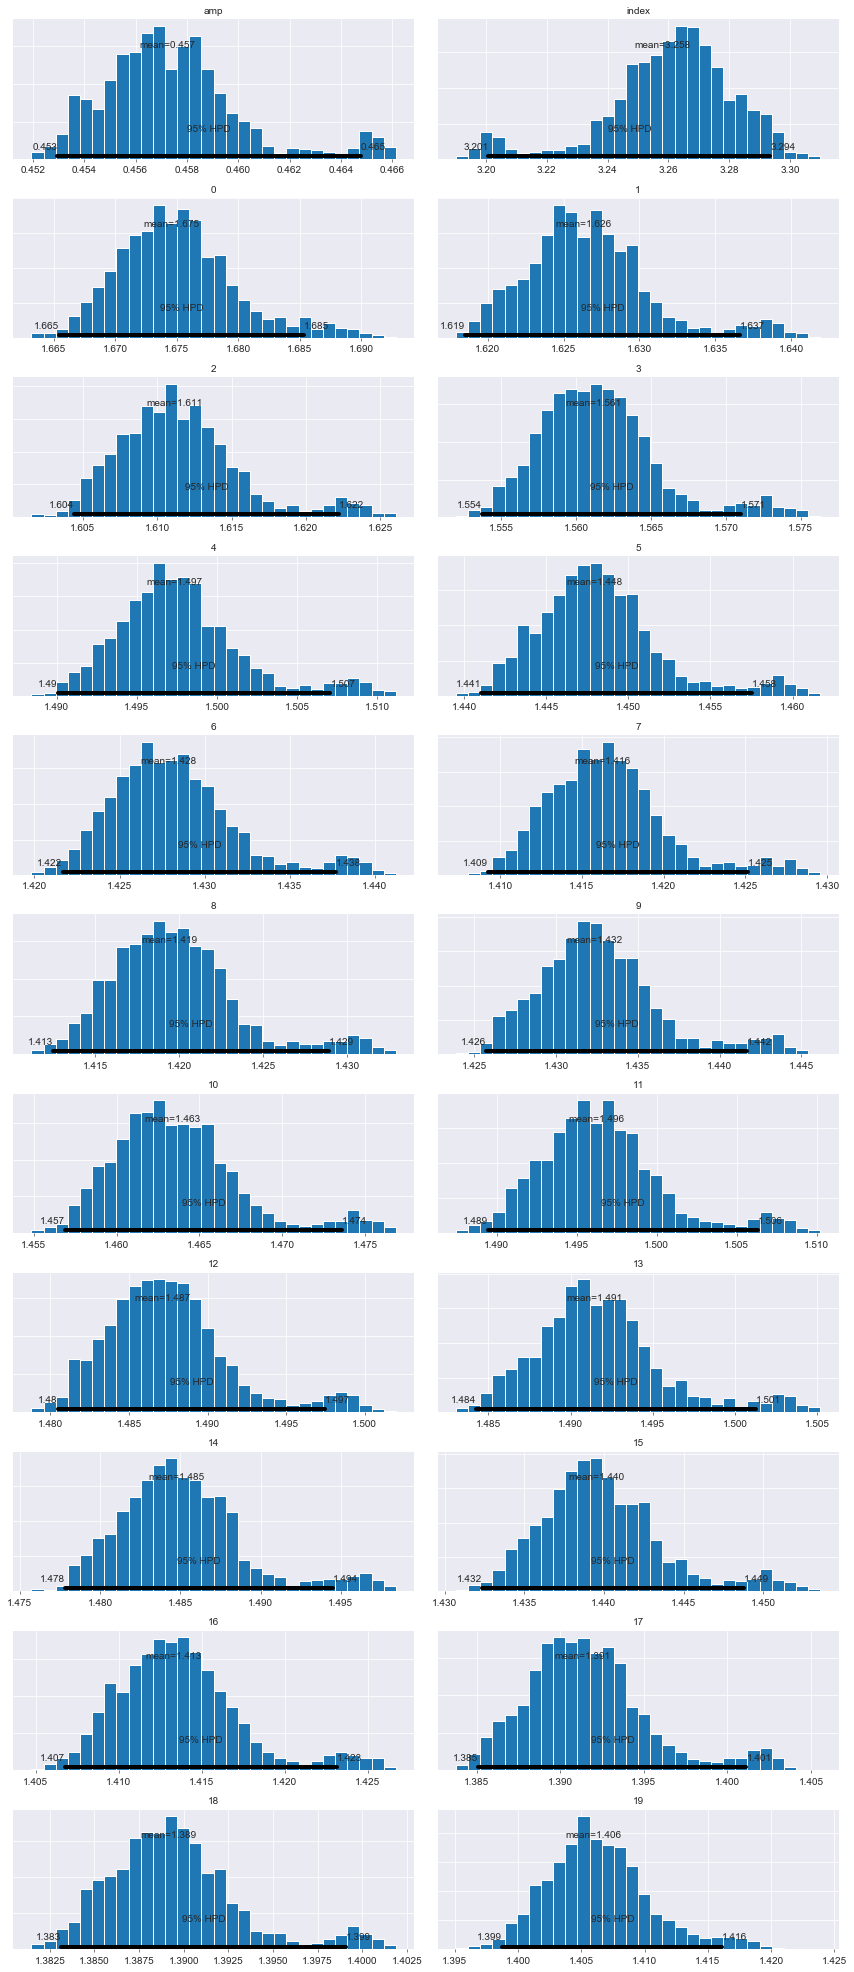

In [52]:
pm.plot_posterior(trace)
plt.show()

In [57]:
from pymc3 import summary

summary(trace, varnames=['amp', 'index'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
amp,0.460374,0.003467,0.000340,0.453936,0.465830,14.662510,1.006447
index,3.233731,0.026515,0.002573,3.193052,3.284112,14.919924,1.006232


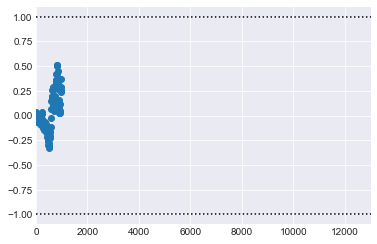

In [38]:
from pymc3 import geweke
    
z = geweke(trace, intervals=100)
#print (z[0])
plt.scatter(*z[0]['index_interval__'].T)
plt.hlines([-1,1], 0, 13000, linestyles='dotted')
plt.xlim(0, 13000)
plt.show()

{'amp': 1.000205248233951, 'index': 1.000542512834227, '0': 0.9997693105857944, '1': 1.0002898621131178, '2': 1.0001421167248439, '3': 1.00001427321386, '4': 1.0009765132980395, '5': 0.9999439870776681, '6': 0.9998412443405716, '7': 1.000429236898017, '8': 1.0009739328792122, '9': 0.9997796241170281}


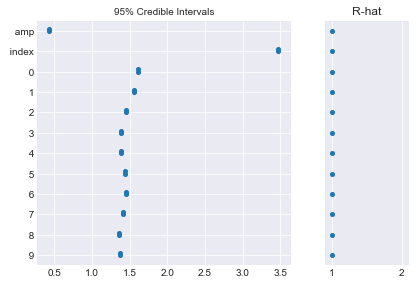

In [39]:
%matplotlib inline  
from pymc3 import forestplot
from pymc3 import gelman_rubin

print (gelman_rubin(trace))

forestplot(trace)